# Learning diffusion with a neural partial differential equation

In [1]:
using LinearAlgebra

using DifferentialEquations
using Flux
using DiffEqFlux

using Plots
default(fmt = :png)

┌ Info: Precompiling DiffEqFlux [aae7a2af-3d4f-5e19-a356-7da93b79d9d0]
└ @ Base loading.jl:1273
┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1273


We want to solve the heat (or diffusion) equation

$$\frac{\partial u}{\partial t} = \kappa \frac{\partial^2 u}{\partial x^2}, \quad x \in \left[-\frac{1}{2}, \frac{1}{2}\right], \quad x\left(-\frac{1}{2}\right) = x\left(\frac{1}{2}\right)$$

Let's go with $N = 16$ grid points and $\kappa = 1$.

In [2]:
const N = 16
const L = 1
const Δx = L / N
const κ = 1

x = range(-L/2, L/2, length=N)

-0.5:0.06666666666666667:0.5

Discretizing the spatial derivative with a second-order centered finite-difference

$$\frac{\partial u_i}{\partial t} = \frac{\partial^2 u}{\partial x^2} \approx \kappa \frac{u_{i-1} - 2u_i + u_{i+1}}{\Delta x^2}$$

we get a system of $N$ coupled ODEs which can be described as

$$ \frac{\partial u}{\partial t} = Au $$

where $A$ is a matrix.

In [3]:
 d = -2 * ones(N) # Diagonal
sd = ones(N-1)    # Sub-diagonals
A = Array(Tridiagonal(sd, d, sd))

# Impose periodic boundary conditions
A[1, N] = 1
A[N, 1] = 1

# Dimensionalize A
A_diffusion = (κ/Δx^2) .* A

function diffusion(∂u∂t, u, p, t)
    ∂u∂t .= A_diffusion * u
    return 
end

diffusion (generic function with 1 method)

Let's generate an initial condition

$$ u_0(x) = e^{-100x^2} $$

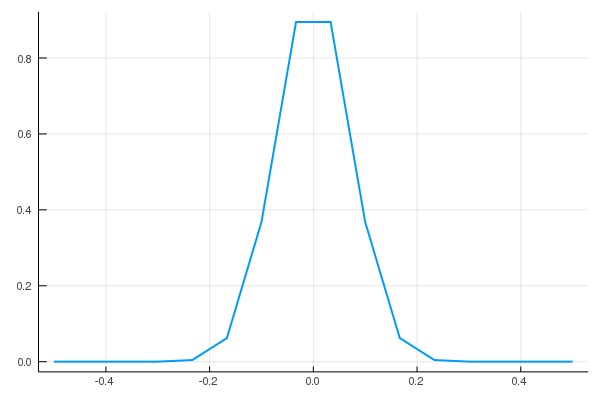

In [4]:
u₀ = @. exp(-100*x^2)

plot(x, u₀, linewidth=2, label="")

We'll pick 30 equally spaced times between $t = 0$ and $t = 0.1$ to save the state of the PDE.

In [5]:
tspan = (0.0, 0.1)
datasize = 30
t = range(tspan[1], tspan[2], length=datasize)

0.0:0.0034482758620689655:0.1

Set up and solve the PDE.

In [6]:
prob = ODEProblem(diffusion, u₀, tspan)
ode_data = Array(solve(prob, Tsit5(), saveat=t))

16×30 Array{Float64,2}:
 1.38879e-11  0.000160344  0.00215047  …  0.158223  0.159223  0.160099
 6.99705e-9   0.00087666   0.00636828     0.159464  0.160304  0.161033
 1.44928e-6   0.00462848   0.0199546      0.161636  0.16221   0.16272 
 0.00012341   0.020396     0.0546109      0.164632  0.16482   0.164975
 0.00432024   0.0726686    0.126828       0.167703  0.167515  0.16736 
 0.0621765    0.201762     0.245097    …  0.170699  0.170125  0.169615
 0.367879     0.417262     0.386382       0.172871  0.172031  0.171302
 0.894839     0.611587     0.48795        0.174112  0.173112  0.172236
 0.894839     0.611587     0.48795        0.174112  0.173112  0.172236
 0.367879     0.417262     0.386382       0.172871  0.172031  0.171302
 0.0621765    0.201762     0.245097    …  0.170699  0.170125  0.169615
 0.00432024   0.0726686    0.126828       0.167703  0.167515  0.16736 
 0.00012341   0.020396     0.0546109      0.164632  0.16482   0.164975
 1.44928e-6   0.00462848   0.0199546      0.161636  0

Let's plot the solution

In [7]:
@gif for n=1:datasize
    plot(x, ode_data[:, n], linewidth=2, ylim=(0, 1), label="", show=false)
end

┌ Info: Saved animation to 
│   fn = /home/alir/6S898-climate-parameterization/notebooks/tmp.gif
└ @ Plots /home/alir/.julia/packages/Plots/Iuc9S/src/animation.jl:95


Plots.AnimatedGif("/home/alir/6S898-climate-parameterization/notebooks/tmp.gif")

Now let's create a two-layer neural network to see if we can learn diffusion

In [9]:
dudt_NN = Chain(Dense(N, 100, tanh),
             Dense(100, N))

Chain(Dense(16, 100, tanh), Dense(100, 16))

Set up a neural PDE that solves the system of ODEs described by

$$ \frac{\partial u}{\partial t} = \text{NN}(u) $$

In [10]:
ps = Flux.params(dudt_NN)
neural_pde_prediction = u₀ -> neural_ode(dudt_NN, u₀, tspan, Tsit5(), saveat=t, reltol=1e-7, abstol=1e-9)

#3 (generic function with 1 method)

Define the loss/objective function to be

$$ \left| u(x, t) - u_{NN}(x, t) \right|^2 \approx \sum_{n=1}^{N_t} \sum_{i=1}^{N_x} \left| u_i^n - (u_{NN})_i^n \right|^2 $$

In [11]:
loss_function() = sum(abs2, ode_data .- neural_pde_prediction(u₀))

loss_function (generic function with 1 method)

Use the Adam optimization algorithm (adaptive moment estimation?). Seems to be recommended as a good default.

In [12]:
data = Iterators.repeated((), 1000)  # Not sure what this does...
opt = ADAM(0.1)

ADAM(0.1, (0.9, 0.999), IdDict{Any,Any}())

Define a callback function to observe training in progress and stop once loss is acceptable.

In [13]:
cb = function ()
  loss = loss_function()
  println("loss = $loss")
  loss < 1 && Flux.stop()
end

cb()

loss = 32.34260936947984 (tracked)


false

Training!

In [14]:
Flux.train!(loss_function, ps, data, opt, cb = cb)

loss = 14.919439710673615 (tracked)
loss = 29.43840212493854 (tracked)
loss = 4.11740918686134 (tracked)
loss = 9.929919102616548 (tracked)
loss = 10.536211872158448 (tracked)
loss = 7.220399984504038 (tracked)
loss = 3.5378539584470605 (tracked)
loss = 4.638787663833674 (tracked)
loss = 5.605911115709756 (tracked)
loss = 2.4427266255905082 (tracked)
loss = 3.167196352029581 (tracked)
loss = 3.694500168316627 (tracked)
loss = 2.9192209946715058 (tracked)
loss = 2.0629625699244163 (tracked)
loss = 1.8976163582212253 (tracked)
loss = 2.0788178960977373 (tracked)
loss = 1.740703197393812 (tracked)
loss = 1.4114189681933784 (tracked)
loss = 1.4670395636395468 (tracked)
loss = 1.3379414659127655 (tracked)
loss = 0.989221998026173 (tracked)
loss = 0.8703405019288393 (tracked)
loss = 1.06083268231298 (tracked)
loss = 1.1374308945047216 (tracked)
loss = 0.91323723645981 (tracked)
loss = 0.6695254507263718 (tracked)
loss = 0.6177383354146027 (tracked)
loss = 0.6682703279556362 (tracked)
loss = 

Let's see how well it fit the training data.

In [16]:
nn_pred = Flux.data(neural_pde_prediction(u₀))

@gif for n=1:datasize
    plot(x, ode_data[:, n], linewidth=2, ylim=(0, 1), label="data", show=false)
    plot!(x, nn_pred[:, n], linewidth=2, ylim=(0, 1), label="Neural PDE", show=false)
end

┌ Info: Saved animation to 
│   fn = /home/alir/6S898-climate-parameterization/notebooks/tmp.gif
└ @ Plots /home/alir/.julia/packages/Plots/Iuc9S/src/animation.jl:95


Plots.AnimatedGif("/home/alir/6S898-climate-parameterization/notebooks/tmp.gif")

Let's see how well it fits

$$ u_0(x) = 1 - cos(2\pi x) $$

In [18]:
u₀_cos = @. 1 - cos(2π * x)

prob = ODEProblem(diffusion, u₀_cos, tspan)
ode_data = Array(solve(prob, Tsit5(), saveat=t))

nn_pred = Flux.data(neural_pde_prediction(u₀_cos))
@gif for n=1:datasize
    plot(x, ode_data[:, n], linewidth=2, ylim=(0, 2), label="data", show=false)
    plot!(x, nn_pred[:, n], linewidth=2, ylim=(0, 2), label="Neural ODE", show=false)
end

┌ Info: Saved animation to 
│   fn = /home/alir/6S898-climate-parameterization/notebooks/tmp.gif
└ @ Plots /home/alir/.julia/packages/Plots/Iuc9S/src/animation.jl:95


Plots.AnimatedGif("/home/alir/6S898-climate-parameterization/notebooks/tmp.gif")